<a href="https://colab.research.google.com/github/DiNOV-Tokyo/yolov5/blob/main/PyTorch_Chapter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chapter4　画像処理と畳み込みニューラルネットワーク

In [ ]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision
!pip3 install tqdm


In [ ]:
import torch
torch.tensor([1,2,3]).to("cuda:0")

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import (Dataset, 
                              DataLoader,
                              TensorDataset)
import tqdm



リスト4.1　Fashion-MNISTのデータからDataLoaderを作成（<your_path>は任意のディレクトリに変更）

In [ ]:
!pwd

/home/jovyan


In [ ]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# 訓練用のデータを取得
# そのままだとPIL（Python Imaging Library）の画像形式で
# Datasetを作ってしまうので、
# transforms.ToTensorでTensorに変換する
fashion_mnist_train = FashionMNIST("./FashionMNIST", 
    train=True, download=False,
    transform=transforms.ToTensor())
# 検証用データの取得
fashion_mnist_test = FashionMNIST("./FashionMNIST",
    train=False, download=False,
    transform=transforms.ToTensor())

# バッチサイズが128のDataLoaderをそれぞれ作成
batch_size=128
train_loader = DataLoader(fashion_mnist_train, 
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fashion_mnist_test,
                         batch_size=batch_size, shuffle=False)

/opt/conda/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


リスト4.2　2層の畳み込み層と2層のMLPをつなげたCNNを作成

In [ ]:
!pip install ipywidgets

     |████████████████████████████████| 121 kB 12.5 MB/s 
     |████████████████████████████████| 243 kB 836 kB/s 
     |████████████████████████████████| 2.2 MB 1.6 MB/s 


In [ ]:
#  (N、C、H、W)形式のTensorを(N, C*H*W)に引き伸ばす層
# 畳み込み層の出力をMLPに渡す際に必要
class FlattenLayer(nn.Module):
    def forward(self, x):
        sizes = x.size()
        return x.view(sizes[0], -1)

# 5×5のカーネルを使用し最初に32個、次に64個のチャンネルを作成する
# BatchNorm2dは画像形式用のBatch Normalization
# Dropout2dは画像形式用のDropout
# 最後にFlattenLayerを挟む
conv_net = nn.Sequential(
    nn.Conv2d(1, 32, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Dropout2d(0.25),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Dropout2d(0.25),
    FlattenLayer()
)

# 畳み込みによって最終的にどのようなサイズになっているかを、
# 実際にダミーデータを入れてみて確認する
test_input = torch.ones(1, 1, 28, 28)
conv_output_size = conv_net(test_input).size()[-1]

# 2層のMLP
mlp = nn.Sequential(
    nn.Linear(conv_output_size, 200),
    nn.ReLU(),
    nn.BatchNorm1d(200),
    nn.Dropout(0.25),
    nn.Linear(200, 10)
)

# 最終的なCNN
net = nn.Sequential(
    conv_net,
    mlp
)

/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


リスト4.3　評価と訓練のヘルパー関数を作成

In [ ]:
# 評価のヘルパー関数
def eval_net(net, data_loader, device="cpu"):
    # DropoutやBatchNormを無効化
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        # toメソッドで計算を実行するデバイスに転送する
        x = x.to(device)
        y = y.to(device)
        # 確率が最大のクラスを予測(リスト2.14参照)
        # ここではforward（推論）の計算だけなので自動微分に
        # 必要な処理はoffにして余計な計算を省く
        with torch.no_grad():
            _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
            # ミニバッチごとの予測結果などを1つにまとめる
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    # 予測精度を計算
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()
  
# 訓練のヘルパー関数
def train_net(net, train_loader, test_loader,
              optimizer_cls=optim.Adam,
              loss_fn=nn.CrossEntropyLoss(),
              n_iter=10, device="cpu"):
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optimizer_cls(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.0
        # ネットワークを訓練モードにする
        net.train()
        n = 0
        n_acc = 0
        # 非常に時間がかかるのでtqdmを使用してプログレスバーを出す
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader),
            total=len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
            _, y_pred = h.max(1)
            n_acc += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        # 訓練データの予測精度
        train_acc.append(n_acc / n)
        # 検証データの予測精度
        val_acc.append(eval_net(net, test_loader, device))
        # このepochでの結果を表示
        print(epoch, train_losses[-1], train_acc[-1],
              val_acc[-1], flush=True)
        

リスト4.4　全パラメータをGPUに転送して訓練を実行

In [ ]:
# ネットワークの全パラメータをGPUに転送
net.to("cuda:0")
# 訓練を実行
train_net(net, train_loader, test_loader, n_iter=20, device="cuda:0")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 68.52it/s]


0 0.44512253003115326 0.8392 0.8804999589920044


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 68.83it/s]


1 0.3215820555630912 0.88185 0.8920999765396118


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 70.25it/s]


2 0.2863958210676399 0.8949166666666667 0.9030999541282654


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 70.11it/s]


3 0.26204113337473994 0.9026166666666666 0.904699981212616


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 70.45it/s]


4 0.24796674472208208 0.9091333333333333 0.9065999984741211


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 69.63it/s]


5 0.23358191890466926 0.9133833333333333 0.9095999598503113


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 68.71it/s]


6 0.22407863590006644 0.91775 0.9115999937057495


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 68.94it/s]


7 0.2132333846937897 0.9213833333333333 0.9125999808311462


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 68.70it/s]


8 0.2074839234447632 0.9228166666666666 0.9103999733924866


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 69.07it/s]


9 0.19981306512704772 0.9249 0.9147999882698059


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 69.07it/s]


10 0.19503884886701903 0.928 0.9146999716758728


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 69.24it/s]


11 0.1882853113974516 0.9298333333333333 0.9175999760627747


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 69.90it/s]


12 0.1803154238841982 0.9329 0.9181999564170837


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 70.50it/s]


13 0.17589581212522382 0.9337833333333333 0.9186999797821045


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 70.63it/s]


14 0.17289475746389127 0.9345666666666667 0.9187999963760376


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 70.10it/s]


15 0.16894635098039085 0.9357166666666666 0.9101999998092651


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 70.02it/s]


16 0.16620049367730433 0.9373 0.9210999608039856


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 70.86it/s]


17 0.16207113572292858 0.9385333333333333 0.9208999872207642


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 71.06it/s]


18 0.1546493203769255 0.9409333333333333 0.9202999472618103


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [00:06<00:00, 70.34it/s]


19 0.15471671549523744 0.9421166666666667 0.9199000000953674


Colaboratory における圧縮ファイルの展開、ディレクトリの作成および移動

In [ ]:
!wget https://github.com/lucidfrontier45/PyTorch-Book/raw/master/data/taco_and_burrito.tar.gz
!tar xf taco_and_burrito.tar.gz

--2021-09-04 11:26:10--  https://github.com/lucidfrontier45/PyTorch-Book/raw/master/data/taco_and_burrito.tar.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lucidfrontier45/PyTorch-Book/master/data/taco_and_burrito.tar.gz [following]
--2021-09-04 11:26:10--  https://raw.githubusercontent.com/lucidfrontier45/PyTorch-Book/master/data/taco_and_burrito.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15292798 (15M) [application/octet-stream]
Saving to: ‘taco_and_burrito.tar.gz’

taco_and_burrito.ta 100%[===================>]  14.58M  --.-KB/s    in 0.1s    

2021-09-04 11:26:11 (103 MB/s) 

In [ ]:
!tar -zxvf taco_and_burrito.tar.gz

taco_and_burrito/
taco_and_burrito/test/
taco_and_burrito/test/burrito/
taco_and_burrito/test/burrito/363.jpg
taco_and_burrito/test/burrito/372.jpg
taco_and_burrito/test/burrito/362.jpg
taco_and_burrito/test/burrito/386.jpg
taco_and_burrito/test/burrito/379.jpg
taco_and_burrito/test/burrito/367.jpg
taco_and_burrito/test/burrito/361.jpg
taco_and_burrito/test/burrito/384.jpg
taco_and_burrito/test/burrito/377.jpg
taco_and_burrito/test/burrito/365.jpg
taco_and_burrito/test/burrito/368.jpg
taco_and_burrito/test/burrito/374.jpg
taco_and_burrito/test/burrito/388.jpg
taco_and_burrito/test/burrito/378.jpg
taco_and_burrito/test/burrito/380.jpg
taco_and_burrito/test/burrito/370.jpg
taco_and_burrito/test/burrito/364.jpg
taco_and_burrito/test/burrito/385.jpg
taco_and_burrito/test/burrito/381.jpg
taco_and_burrito/test/burrito/383.jpg
taco_and_burrito/test/burrito/373.jpg
taco_and_burrito/test/burrito/366.jpg
taco_and_burrito/test/burrito/389.jpg
taco_and_burrito/test/burrito/376.jpg
taco_and_burrito

リスト4.5　DataLoaderを作成（<your_path>を変更している）

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# ImageFolder関数を使用してDatasetを作成する
train_imgs = ImageFolder(
    "taco_and_burrito/train/",
    transform=transforms.Compose([
      transforms.RandomCrop(224),
      transforms.ToTensor()]
))
test_imgs = ImageFolder(
    "taco_and_burrito/test/",
    transform=transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor()]
))

# DataLoaderを作成
train_loader = DataLoader(
    train_imgs, batch_size=32, shuffle=True)
test_loader = DataLoader(
    test_imgs, batch_size=32, shuffle=False)

リスト4.6　クラス名とクラスインデクスの対応の確認

In [ ]:
print(train_imgs.classes)

['burrito', 'taco']


In [ ]:
print(train_imgs.class_to_idx)

{'burrito': 0, 'taco': 1}


リスト4.7　事前学習済み（Pre-trained）のモデルのロードと定義

In [ ]:
from torchvision import models

# 事前学習済みのresnet18をロード
net = models.resnet18(pretrained=True)

# すべてのパラメータを微分対象外にする
for p in net.parameters():
    p.requires_grad=False
    
# 最後の線形層を付け替える
fc_input_dim = net.fc.in_features
net.fc = nn.Linear(fc_input_dim, 2)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

リスト4.8　モデルの訓練関数の記述

In [ ]:
def eval_net(net, data_loader, device="cpu"):
    # DropoutやBatchNormを無効化
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        # toメソッドで計算を実行するデバイスに転送する
        x = x.to(device)
        y = y.to(device)
        # 確率が最大のクラスを予測(リスト2.14参照)
        # ここではforward（推論）の計算だけなので自動微分に
        # 必要な処理はoffにして余計な計算を省く
        with torch.no_grad():
            _, y_pred = net(x).max(1)
        ys.append(y)
        ypreds.append(y_pred)
    # ミニバッチごとの予測結果などを1つにまとめる
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    # 予測精度を計算
    acc = (ys == ypreds).float().sum() / len(ys)
    return acc.item()

def train_net(net, train_loader, test_loader,
              only_fc=True,
              optimizer_cls=optim.Adam,
              loss_fn=nn.CrossEntropyLoss(),
              n_iter=10, device="cpu"):
    train_losses = []
    train_acc = []
    val_acc = []
    if only_fc:
        # 最後の線形層のパラメータのみを、
        # optimizerに渡す
        optimizer = optimizer_cls(net.fc.parameters())
    else:
        optimizer = optimizer_cls(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.0
        # ネットワークを訓練モードにする
        net.train()
        n = 0
        n_acc = 0
        # 非常に時間がかかるのでtqdmを使用してプログレスバーを出す
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader),
            total=len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            h = net(xx)
            loss = loss_fn(h, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
            _, y_pred = h.max(1)
            n_acc += (yy == y_pred).float().sum().item()
        train_losses.append(running_loss / i)
        # 訓練データの予測精度
        train_acc.append(n_acc / n)
        # 検証データの予測精度
        val_acc.append(eval_net(net, test_loader, device))
        # このepochでの結果を表示
        print(epoch, train_losses[-1], train_acc[-1],
              val_acc[-1], flush=True)

リスト4.9　全パラメータをGPUに転送して訓練を実行

In [ ]:
# ネットワークの全パラメータをGPUに転送
net.to("cuda:0")

# 訓練を実行
train_net(net, train_loader, test_loader, n_iter=20, device="cuda:0")

  0%|          | 0/23 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 23/23 [00:04<00:00,  5.45it/s]


0 0.6962381465868517 0.5969101123595506 0.7833333611488342


100%|██████████| 23/23 [00:03<00:00,  5.86it/s]


1 0.5325466191226785 0.7556179775280899 0.8500000238418579


100%|██████████| 23/23 [00:03<00:00,  6.06it/s]


2 0.44941933859478345 0.8103932584269663 0.8333333730697632


100%|██████████| 23/23 [00:03<00:00,  6.07it/s]


3 0.4419420456344431 0.8314606741573034 0.8500000238418579


100%|██████████| 23/23 [00:03<00:00,  6.22it/s]


4 0.42117051915688947 0.8342696629213483 0.8666667342185974


100%|██████████| 23/23 [00:03<00:00,  6.29it/s]


5 0.4170862219550393 0.8286516853932584 0.8500000238418579


100%|██████████| 23/23 [00:03<00:00,  6.31it/s]


6 0.36120365221392026 0.8721910112359551 0.8166667222976685


100%|██████████| 23/23 [00:03<00:00,  6.50it/s]


7 0.3497591587630185 0.8764044943820225 0.8500000238418579


100%|██████████| 23/23 [00:03<00:00,  6.50it/s]


8 0.3574773113835942 0.8595505617977528 0.8500000238418579


100%|██████████| 23/23 [00:03<00:00,  6.65it/s]


9 0.3441563221541318 0.8679775280898876 0.7333333492279053


100%|██████████| 23/23 [00:03<00:00,  6.60it/s]


10 0.3755670806223696 0.8525280898876404 0.8666667342185974


100%|██████████| 23/23 [00:03<00:00,  6.66it/s]


11 0.3379109515385194 0.8595505617977528 0.8666667342185974


100%|██████████| 23/23 [00:03<00:00,  6.63it/s]


12 0.3406079641797326 0.8721910112359551 0.8666667342185974


100%|██████████| 23/23 [00:03<00:00,  6.46it/s]


13 0.32540619508786633 0.8735955056179775 0.8333333730697632


100%|██████████| 23/23 [00:03<00:00,  6.22it/s]


14 0.37341703609986737 0.8398876404494382 0.8833333849906921


100%|██████████| 23/23 [00:03<00:00,  6.22it/s]


15 0.32819497653029184 0.8792134831460674 0.8666667342185974


100%|██████████| 23/23 [00:03<00:00,  6.33it/s]


16 0.3229938887737014 0.8637640449438202 0.8666667342185974


100%|██████████| 23/23 [00:03<00:00,  6.34it/s]


17 0.31636354801329697 0.8707865168539326 0.8666667342185974


100%|██████████| 23/23 [00:03<00:00,  6.30it/s]


18 0.3169360926205462 0.8778089887640449 0.8833333849906921


100%|██████████| 23/23 [00:03<00:00,  6.50it/s]


19 0.3055296689271927 0.8932584269662921 0.8333333730697632


リスト4.10　入力をそのまま出力するダミーの層を作り、fcを置き換える

In [ ]:
class IdentityLayer(nn.Module):
    def forward(self, x):
        return x
    
net = models.resnet18(pretrained=True)
for p in net.parameters():
    p.requires_grad=False
net.fc = IdentityLayer()

リスト4.11　筆者が作成したCNNモデルの実行

In [ ]:
conv_net = nn.Sequential(
    nn.Conv2d(3, 32, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    nn.Conv2d(32, 64, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, 128, 5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    FlattenLayer()
)

# 畳み込みによって最終的にどのようなサイズになっているかを、
# 実際にデータを入れて確認する
test_input = torch.ones(1, 3, 224, 224)
conv_output_size = conv_net(test_input).size()[-1]

# 最終的なCNN
net = nn.Sequential(
    conv_net,
    nn.Linear(conv_output_size, 2)
)

# 訓練を実行
train_net(net, train_loader, test_loader, n_iter=10,
          only_fc=False)

Colaboratory における圧縮ファイルの展開、ディレクトリの作成および移動

In [1]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
!tar xf lfw-deepfunneled.tgz
!mkdir lfw-deepfunneled/train
!mkdir lfw-deepfunneled/test
!mv lfw-deepfunneled/[A-S]* lfw-deepfunneled/train
!mv lfw-deepfunneled/[U-Y]* lfw-deepfunneled/train
!mv lfw-deepfunneled/[Z]* lfw-deepfunneled/test

--2021-09-05 00:26:27--  http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108761145 (104M) [application/x-gzip]
Saving to: ‘lfw-deepfunneled.tgz’

lfw-deepfunneled.tg 100%[===================>] 103.72M  49.0MB/s    in 2.1s    

2021-09-05 00:26:29 (49.0 MB/s) - ‘lfw-deepfunneled.tgz’ saved [108761145/108761145]



In [ ]:
!rmdir -f lfw-deepfunneled

rmdir: invalid option -- 'f'
Try 'rmdir --help' for more information.


In [ ]:
#!mkdir lfw-deepfunneled/train
!mkdir lfw-deepfunneled/test
#!mv lfw-deepfunneled/[A-W]* lfw-deepfunneled/train
!mv lfw-deepfunneled/[X-Z]* lfw-deepfunneled/test

リスト4.12　32×32ピクセルの画像を128×128ピクセルに拡大する

In [ ]:
class DownSizedPairImageFolder(ImageFolder):
    def __init__(self, root, transform=None, 
                 large_size=128, small_size=32, **kwds):
        super().__init__(root, transform=transform, **kwds)
        self.large_resizer = transforms.Resize(large_size)
        self.small_resizer = transforms.Resize(small_size)
        
    def __getitem__(self, index):
        path, _ = self.imgs[index]
        img = self.loader(path)
        
        # 読み取った画像を128×128ピクセルと32×32ピクセルにリサイズする
        large_img = self.large_resizer(img)
        small_img = self.small_resizer(img)
            
        # その他の変換を適用する
        if self.transform is not None:
            large_img = self.transform(large_img)
            small_img = self.transform(small_img)
        
        # 32ピクセルの画像と128ピクセルの画像を返す
        return small_img, large_img

リスト4.13　訓練用と検証用のDataLoaderを作成（<your_path>を変更している）

In [ ]:
import os
path = 'lfw-deepfunneled/train'
i = 0
for d, s, f in os.walk(path):
    if ".jpg" in f:
      continue
    else:
      i = i + 1

print(i)
  #print('')
  #print('── {}'.format(d))
  #print(' └── {}'.format(s))
  #print('   └── {}'.format(f))

5673


In [ ]:
test_data = DownSizedPairImageFolder(
    "lfw-deepfunneled/test",
    transform=transforms.ToTensor())

train_data = DownSizedPairImageFolder(
    "lfw-deepfunneled/train", 
    transform=transforms.ToTensor())

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, 
                          shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=4)

FileNotFoundError: ignored

リスト4.14　モデルの作成

In [ ]:
net = nn.Sequential(
    nn.Conv2d(3, 256, 4,
              stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 4,
              stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(512),
    nn.ConvTranspose2d(512, 256, 4,
                       stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.ConvTranspose2d(256, 128, 4,
                       stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.ConvTranspose2d(128, 64, 4,
                       stride=2, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.ConvTranspose2d(64, 3, 4,
                       stride=2, padding=1)
)

リスト4.15　PSNRの計算

In [ ]:
import math
def psnr(mse, max_v=1.0):
    return 10 * math.log10(max_v**2 / mse)
  
# 評価のヘルパー関数
def eval_net(net, data_loader, device="cpu"):
  
    # DropoutやBatchNormを無効化
    net.eval()
    ys = []
    ypreds = []
    for x, y in data_loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            y_pred = net(x)
        ys.append(y)
        ypreds.append(y_pred)
    
    # ミニバッチごとの予測結果などを1つにまとめる
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    
    # 予測精度(MSE)を計算
    score = nn.functional.mse_loss(ypreds, ys).item()
    return score

# 訓練のヘルパー関数
def train_net(net, train_loader, test_loader,
              optimizer_cls=optim.Adam,
              loss_fn=nn.MSELoss(),
              n_iter=10, device="cpu"):
    train_losses = []
    train_acc = []
    val_acc = []
    optimizer = optimizer_cls(net.parameters())
    for epoch in range(n_iter):
        running_loss = 0.0
        
        # ネットワークを訓練モードにする
        net.train()
        n = 0
        score = 0
        
        # 非常に時間がかかるのでtqdmを
        # 使用してプログレスバーを出す
        for i, (xx, yy) in tqdm.tqdm(enumerate(train_loader),
            total=len(train_loader)):
            xx = xx.to(device)
            yy = yy.to(device)
            y_pred = net(xx)
            loss = loss_fn(y_pred, yy)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n += len(xx)
        train_losses.append(running_loss / len(train_loader))
        
        # 検証データの予測精度
        val_acc.append(eval_net(net, test_loader, device))
        
        # このepochでの結果を表示
        print(epoch, train_losses[-1], 
              psnr(train_losses[-1]), psnr(val_acc[-1]), flush=True)

リスト4.16　複数回の演算（10回）

In [ ]:
net.to("cuda:0")
train_net(net, train_loader, test_loader, device="cuda:0")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 6/6 [00:00<00:00,  6.31it/s]


0 1.0732399225234985 -0.3069681924513246 6.282751049507505


100%|██████████| 6/6 [00:00<00:00,  7.58it/s]


1 0.3000883062680562 5.227509276747934 6.46414097689548


100%|██████████| 6/6 [00:00<00:00,  7.42it/s]


2 0.2431973690787951 6.140411275931427 7.48119600251234


100%|██████████| 6/6 [00:00<00:00,  7.11it/s]


3 0.19139436880747476 7.180708441548752 8.067832251894364


100%|██████████| 6/6 [00:00<00:00,  7.19it/s]


4 0.20374139149983725 6.909207320510502 8.081694183553523


100%|██████████| 6/6 [00:00<00:00,  7.34it/s]


5 0.134622473269701 8.708824348941409 8.985924234323086


100%|██████████| 6/6 [00:00<00:00,  7.19it/s]


6 0.10467398663361867 9.801612348939365 9.995534960372225


100%|██████████| 6/6 [00:00<00:00,  7.35it/s]


7 0.08665092537800471 10.6222679493027 10.86833016589505


100%|██████████| 6/6 [00:00<00:00,  7.20it/s]


8 0.06321198803683122 11.992005507599057 12.081589259878637


100%|██████████| 6/6 [00:00<00:00,  7.55it/s]


9 0.045207615941762924 13.44788395213821 13.617414101843643


リスト4.17　画像を拡大してオリジナルと比較する

In [ ]:
from torchvision.utils import save_image

# テストのデータセットからランダムに4つずつ取り出すDataLoader
random_test_loader = DataLoader(test_data, batch_size=4, shuffle=True)

# DataLoaderをPythonのイテレータに変換し、4つ例を取り出す
it = iter(random_test_loader)
x, y = next(it)

# Bilinearで拡大
bl_recon = torch.nn.functional.upsample(x, 128, mode="bilinear", align_corners=True)

# CNNで拡大
yp = net(x.to("cuda:0")).to("cpu")

# torch.catでオリジナル,Bilinear,CNNの画像を結合し
# save_imageで画像ファイルに書き出し
save_image(torch.cat([y, bl_recon, yp], 0), "cnn_upscale.jpg", nrow=4)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


生成ファイルの確認

In [ ]:
!ls

Colaboratory における画像の表示

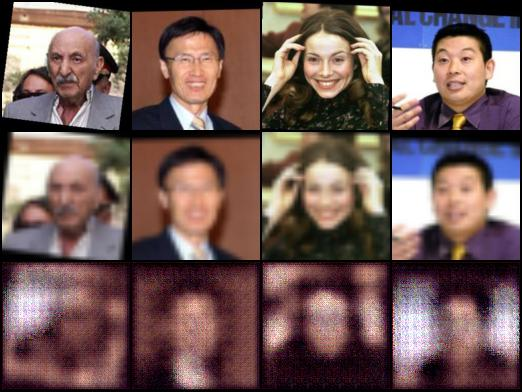

In [ ]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('cnn_upscale.jpg'))

Colaboratory における圧縮ファイルの展開、ディレクトリの作成および移動

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!tar xf 102flowers.tgz
!mkdir oxford-102
!mkdir oxford-102/jpg
!mv jpg/*.jpg oxford-102/jpg

リスト4.18　DataLoaderの準備（<your_path>を変更している）

In [ ]:
img_data = ImageFolder("oxford-102/",
    transform=transforms.Compose([
        transforms.Resize(80),
        transforms.CenterCrop(64),
        transforms.ToTensor()
]))

batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size,
                        shuffle=True)

リスト4.19　画像の生成モデルを組み立てる

In [ ]:
nz = 100
ngf = 32

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, 3,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.main(x)
        return out

リスト4.20　画像の識別モデルを組み立てる

In [ ]:
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

リスト4.21　訓練関数の作成

In [ ]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

# Adamのパラメータは元論文の提案値
opt_d = optim.Adam(d.parameters(),
    lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(),
    lr=0.0002, betas=(0.5, 0.999))

# クロスエントロピーを計算するための補助変数など
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# モニタリング用のz
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

リスト4.22　訓練関数

In [ ]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    # 生成モデル、識別モデルの目的関数の追跡用の配列
    log_loss_g = []
    log_loss_d = []
    for real_img, _ in tqdm.tqdm(loader):
        batch_len = len(real_img)
        
         # 実際の画像をGPUにコピー
        real_img = real_img.to("cuda:0")
        
         # 偽画像を乱数と生成モデルから作る
        z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
        fake_img = g(z)
        
        # 後で使用するので偽画像の値のみ取り出しておく
        fake_img_tensor = fake_img.detach()
        
        # 偽画像に対する生成モデルの評価関数を計算する
        out = d(fake_img)
        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())
        
        # 計算グラフが生成モデルと識別モデルの両方に
        # 依存しているので両者とも勾配をクリアしてから
        # 微分の計算とパラメータ更新を行う
        d.zero_grad(), g.zero_grad()
        loss_g.backward()
        opt_g.step()

        # 実際の画像に対する識別モデルの評価関数を計算
        real_out = d(real_img)
        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        # PyTorchでは同じTensorを含んだ計算グラフに対して
        # 2回backwardを行うことができないので保存してあった
        # Tensorを使用して無駄な計算を省く
        fake_img = fake_img_tensor
        
        # 偽画像に対する識別モデルの評価関数の計算
        fake_out = d(fake_img_tensor)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        # 実偽の評価関数の合計値
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        # 識別モデルの微分計算とパラメータ更新
        d.zero_grad(), g.zero_grad()
        loss_d.backward()
        opt_d.step()
        
    return mean(log_loss_g), mean(log_loss_d)

リスト4.23　DCGANの訓練（<your_path>を変更している）

In [ ]:
for epoch in range(300):
    train_dcgan(g, d, opt_g, opt_d, img_loader)
    # 10回の繰り返しごとに学習結果を保存する
    if epoch % 10 == 0:
        # パラメータの保存
        torch.save(
            g.state_dict(),
            "oxford-102/g_{:03d}.prm".format(epoch),
            pickle_protocol=4)
        torch.save(
            d.state_dict(),
            "oxford-102/d_{:03d}.prm".format(epoch),
            pickle_protocol=4)
        # モニタリング用のzから生成した画像を保存
        generated_img = g(fixed_z)
        save_image(generated_img,
                   "oxford-102/{:03d}.jpg".format(epoch))

生成ファイルの確認

In [ ]:
!ls oxford-102/

Colaboratory における画像の表示

In [ ]:
from IPython.display import Image,display_jpeg
display_jpeg(Image('oxford-102/000.jpg'))